# Ensemble Learning through Splitting (base case)

for each of the M predictors: trainset= k-th block of size X.shape[0]/M
bc data is split in M distinct subsets on which each learner is trained

$\implies$  hyperparam = M = #learners


Ofc the optimal M will depend on the size of the trainset as you are making a bias-variance tradeoff which largely depends on the datasize

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
## ENSMBLE

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from aggregating.models import SimpleSplitter

## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train = 5000
N_test = 50000
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.0793534441124991

## Create Custom Models
(to have more control of splitting etc)

In [8]:
### Defined in aggregating module
s = SimpleSplitter(11,None)
s.get_params()

{'M': 11, 'predictor': None}

## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [9]:
from aggregating.gridsearch import evaluate_model,create_logger
from aggregating.utils import flatten_X

In [10]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

# GRIDSEARCH PARAMS
model = SimpleSplitter(0,GaussianProcessRegressor(kernel))
trials = 3
M_grid = np.arange(1,7)
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(cpu_count()-1)
for m in M_grid:
    print(m,trials)
    hyperparams = {'M':m}
    pool.apply_async(evaluate_model,args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel),
                                        callback = create_logger(hyperparams,results))
pool.close()
pool.join()


1 3
2 {'M': 1} -> thread id = 19528
fit
(5000, 2)
 3
3 {'M': 2} -> thread id = 16772 3

fit
(5000, 2)
4 {'M': 3} -> thread id = 28904
fit
(5000, 2)
 3
5 {'M': 4} -> thread id = 25860
fit 3

(5000, 2)
6 {'M': 5} -> thread id = 34488
fit
(5000, 2)
 3
 {'M': 6} -> thread id = 5152
fit
(5000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
predict
(50000, 2)
{'M': 3} , 0 -> 0.21707157022467766
[0.21707157022467766]
predict
(50000, 2)
{'M': 1} , 0 -> 0.1687141343209073
[0.1687141343209073]
predict
(50000, 2)
{'M': 5} , 0 -> 0.1719417158857009
[0.1719417158857009]
predict
(50000, 2)
{'M': 4} , 0 -> 0.1589274173872353
[0.1589274173872353]
predict
(50000, 2)
{'M': 2} , 0 -> 0.19516054947812508
[0.19516054947812508]
predict
(50000, 2)
{'M': 6} , 0 -> 0.23863458184719571
[0.23863458184719571]
predict
(50000, 2)
{'M': 3} , 1 -> 0.21673192587728654
[0.21707157022467766, 0.21673192587728654]
{'M': 1} , 1 -> 0.14545842080311586
[0.1687141343209073, 0

In [11]:
converted_results = np.ones((len(M_grid)+1,trials))*(-1)
for item in results:
    converted_results[item[0]] = item[1]
print(converted_results)
print(results)

[[-1.         -1.         -1.        ]
 [ 0.16871413  0.14545842  0.13471313]
 [ 0.19516055  0.16719169  0.14463307]
 [ 0.21707157  0.21673193  0.23590126]
 [ 0.15892742  0.19806073  0.18144397]
 [ 0.17194172  0.15682053  0.15355671]
 [ 0.23863458  0.19600179  0.18343199]]
[[1, [0.1687141343209073, 0.14545842080311586, 0.1347131295211446]], [3, [0.21707157022467766, 0.21673192587728654, 0.2359012586867413]], [4, [0.1589274173872353, 0.19806072536499802, 0.18144397378481195]], [5, [0.1719417158857009, 0.15682053206574187, 0.1535567108363164]], [2, [0.19516054947812508, 0.16719168942451423, 0.14463306789258618]], [6, [0.23863458184719571, 0.19600179197676443, 0.18343199348364028]]]


In [12]:
masked_results= np.ma.masked_where(converted_results[1:] <= 0.0,converted_results[1:]) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=1)
sigmas = masked_results.std(axis=1)


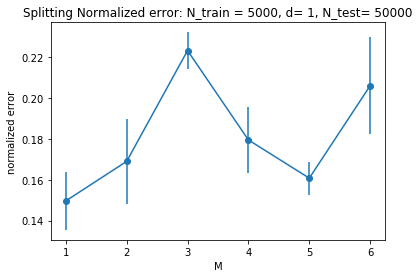

In [13]:
plt.errorbar(np.array(M_grid),means,sigmas,marker ='o')
plt.title(f"Splitting Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.ylabel("normalized error")
plt.show()

**bottom line: Splitting is not interesting and is hard to quantify as it's results depend very strongly on the size of the dataset**


In [14]:
#

In [17]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid.tolist(), 'errors': converted_results.tolist()}

In [18]:
import json
import datetime
with open(f'_splitting{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)